<a href="https://colab.research.google.com/github/Guillem96/activity-recognition/blob/master/notebooks/Audio%20Classification%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/Guillem96/activity-recognition
!cd activity-recognition && pip install -e .

Obtaining file:///content/activity-recognition
     |████████████████████████████████| 81kB 7.7MB/s 
     |████████████████████████████████| 37.2MB 1.3MB/s 
     |████████████████████████████████| 1.9MB 32.3MB/s 
     |████████████████████████████████| 911kB 45.3MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Running setup.py develop for ar


In [1]:
import sys
import random
from pathlib import Path

import accelerate

import torch
import torchaudio
import torchvision.transforms as T

import matplotlib.pyplot as plt

from ar.metrics import accuracy, top_5_accuracy
from ar.utils.engine import train_one_epoch, evaluate

In [3]:
!mkdir -p data/speech_command

In [4]:
ds = torchaudio.datasets.SPEECHCOMMANDS('data/speech_command', download=True)

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [6]:
classes = Path('data/speech_command/SpeechCommands/speech_commands_v0.02')
classes = [p.stem for p in classes.iterdir()]
class2idx = {c: i for i, c in enumerate(classes)}

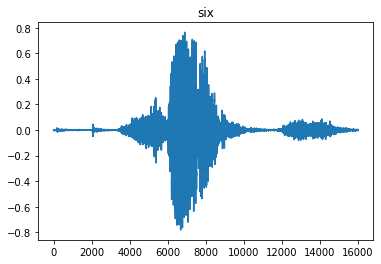

In [7]:
waveform, sample_rate, label, *_ = ds[random.randint(0, len(ds))]
plt.title(label)
plt.plot(waveform[0].numpy());

In [8]:
from IPython.display import Audio
Audio(waveform.numpy(), rate=sample_rate, autoplay=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:645: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


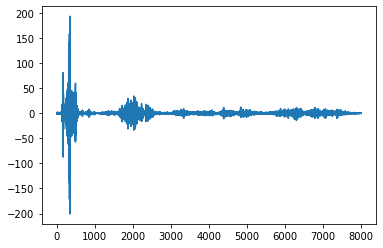

In [12]:
fft = torch.fft.rfft(waveform, dim=1)
plt.plot(fft[0]);

## MelSpectrogram from scratch

Apply a Short Time Fourier Transform to our signal with a Hanning Window.

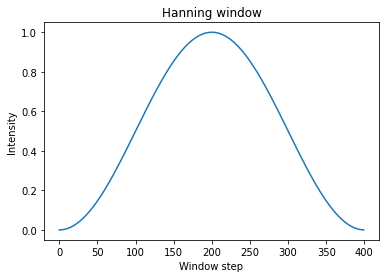

In [13]:
plt.title('Hanning window')
plt.plot(torch.hann_window(400))
plt.xlabel('Window step')
plt.ylabel('Intensity')
plt.show()

In [14]:
window_len = 400
hop_len = 160

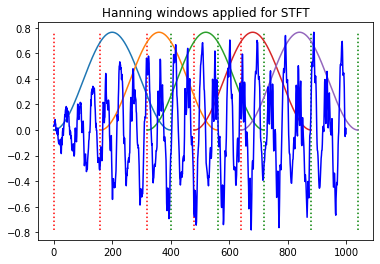

In [15]:
sample_wf = waveform.squeeze()[6000:7000]

plt.title('Hanning windows applied for STFT')
for i in range((sample_wf.size(0) // hop_len) - 1):
    plt.plot(range(i * hop_len, (i * hop_len) + window_len), 
             torch.hann_window(window_len) * sample_wf.max())
    plt.vlines(i * hop_len, 
               sample_wf.min(), 
               sample_wf.max(),
               color='r',
               linestyles='dotted')
    plt.vlines((i * hop_len) + window_len, 
               sample_wf.min(), 
               sample_wf.max(),
               color='g',
               linestyles='dotted')


plt.plot(sample_wf, 'b')
plt.show()


/usr/local/lib/python3.7/dist-packages/torch/functional.py:472: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:664.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: torchaudio.functional.functional.complex_norm has been deprecated and will be removed from future release. Please convert the input Tensor to complex type with `torch.view_as_complex` then use `torch.abs`. Please refer to https://github.com/pytorch/audio/issues/1337 for more details about torchaudio's plan to migrate to native complex type.
  


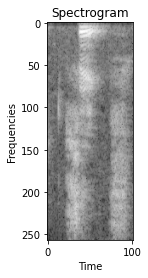

In [16]:
stft = torch.stft(waveform.squeeze(), 
                  n_fft=512, 
                  hop_length=hop_len, 
                  win_length=window_len,
                  window=torch.hann_window(400))
stft = torchaudio.functional.complex_norm(stft)

plt.title('Spectrogram')
plt.imshow(stft.log2().squeeze(), cmap='gray')
plt.xlabel('Time')
plt.ylabel('Frequencies')
plt.show()

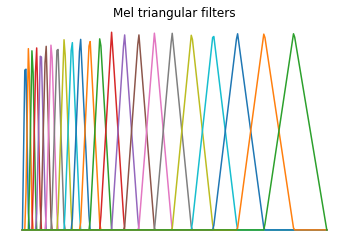

In [17]:
fbanks = torchaudio.functional.create_fb_matrix(
    stft.size(0), 
    0, sample_rate // 2, 
    23, sample_rate)

plt.title('Mel triangular filters')
plt.plot(fbanks)
plt.axis('off')
plt.show()

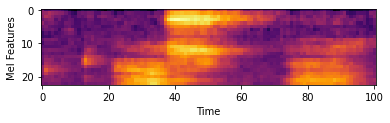

In [18]:
mel_spectogram = stft.transpose(1, 0) @ fbanks
plt.imshow(mel_spectogram.log2().t(), cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Mel Features')
plt.show()

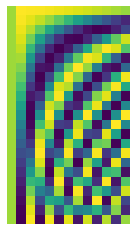

In [19]:
cosine_trans = torchaudio.functional.create_dct(13, 23, 'ortho')
plt.imshow(cosine_trans)
plt.axis('off');

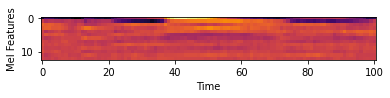

In [20]:
mfcc = (mel_spectogram + 1e-6).log() @ cosine_trans
plt.imshow(mfcc.t(), cmap='inferno')
plt.xlabel('Time')
plt.ylabel('Mel Features')
plt.show()

In [21]:
train_len = int(len(ds) * .9)
rand_idx = torch.randperm(len(ds))

train_ds = torch.utils.data.Subset(ds, rand_idx[:train_len])
valid_ds = torch.utils.data.Subset(ds, rand_idx[train_len:])

In [22]:
def collate_fn(batch):
    wf, sr, labels, *_ = zip(*batch)
    padded_wf = []
    
    max_len = max([o.size(1) for o in wf])
    for w in wf:
        w = w[:, :max_len]
        offset = max_len - w.size(1)
        pad_tensor = torch.zeros(1, offset)
        w = torch.cat([w, pad_tensor], dim=-1)
        padded_wf.append(w)

    wf = torch.stack(padded_wf)
    return wf, torch.as_tensor([class2idx[o] for o in labels])

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=64, collate_fn=collate_fn, pin_memory=True)

valid_dl = torch.utils.data.DataLoader(
    valid_ds, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [23]:
x, y = next(iter(train_dl))
x.size(), y.size()

(torch.Size([64, 1, 16000]), torch.Size([64]))

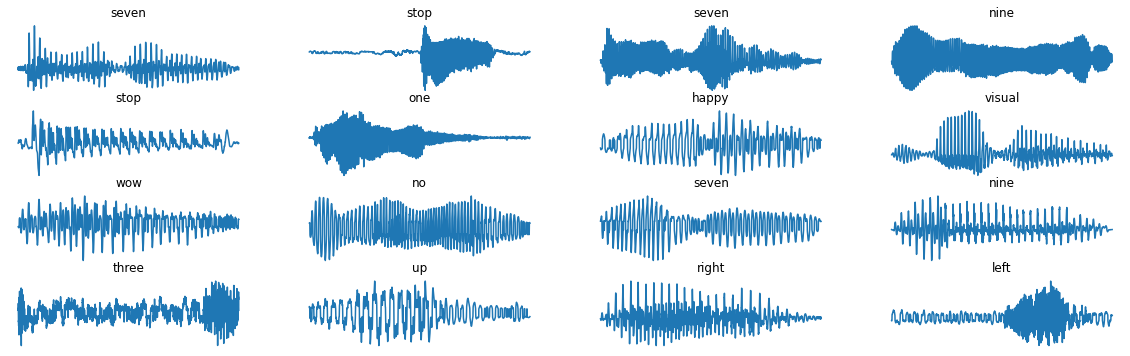

In [24]:
def show_batch(waveforms, labels):
    plt.figure(figsize=(20, 6))
    for i, (wf, l) in enumerate(zip(waveforms[:16], labels[:16])):
        plt.subplot(4, 4, i + 1)
        
        # Remove background noise and padding
        # to plot only the audio of interest
        wf = wf.squeeze().unfold(0, 20, 1).mean(-1)
        wf = wf[wf.abs() > 0.005]
        
        plt.title(classes[l.item()])
        plt.plot(wf.numpy())
        plt.axis('off')

show_batch(x, y)
plt.show()

In [31]:
device = torch.device('cuda')

model = torch.nn.Sequential(
    torchaudio.transforms.MFCC(sample_rate, 20, log_mels=True, 
                               melkwargs=dict(n_fft=512, 
                                              win_length=400, 
                                              hop_length=160)),
    torch.nn.Conv2d(1, 32, 5),
    torch.nn.Conv2d(32, 32, 3),
    torch.nn.BatchNorm2d(32),
    torch.nn.ReLU(inplace=True),
    torch.nn.Conv2d(32, 64, 3),
    torch.nn.Conv2d(64, 64, 3),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(inplace=True),
    torch.nn.Flatten(1),
    torch.nn.Linear(58240, 512),
    torch.nn.Dropout(.5),
    torch.nn.Linear(512, len(classes)),
    torch.nn.LogSoftmax(-1))

optimzer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.NLLLoss()

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


In [29]:
accelerator = accelerate.Accelerator()
accelerator.device

device(type='cuda')

In [33]:
model, train_dl, valid_dl, optimizer = accelerator.prepare(model, train_dl, valid_dl, optimzer)

In [ ]:
for epoch in range(5):
    train_one_epoch(train_dl, model, optimizer, loss_fn, epoch, 
                    accelerator=accelerator)

    evaluate(valid_dl, model, loss_fn, 
             metrics=[accuracy, top_5_accuracy], accelerator=accelerator)


Epoch[0]:   0%|          | 0/1489 [00:00<?, ?it/s]